1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Error in Kansas: Shape of passed values is (456, 4), indices imply (456, 5)
Error in Kentucky: Shape of passed values is (456, 4), indices imply (456, 5)
Error in Louisiana: Shape of passed values is (456, 4), indices imply (456, 5)
Error in Maine: Shape of passed values is (456, 4), indices imply (456, 5)
Error in Maryland: Shape of passed values is (456, 4), indices imply (456, 5)
Error in Massachusetts: Shape of pas

/opt/anaconda3/envs/RISE_PROJECT/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['initial_claims']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/anaconda3/envs/RISE_PROJECT/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['initial_claims']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/anaconda3/envs/RISE_PROJECT/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['initial_claims']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/anaconda3/envs/RISE_PROJECT/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['initial_claims']. At least one non-missing value 

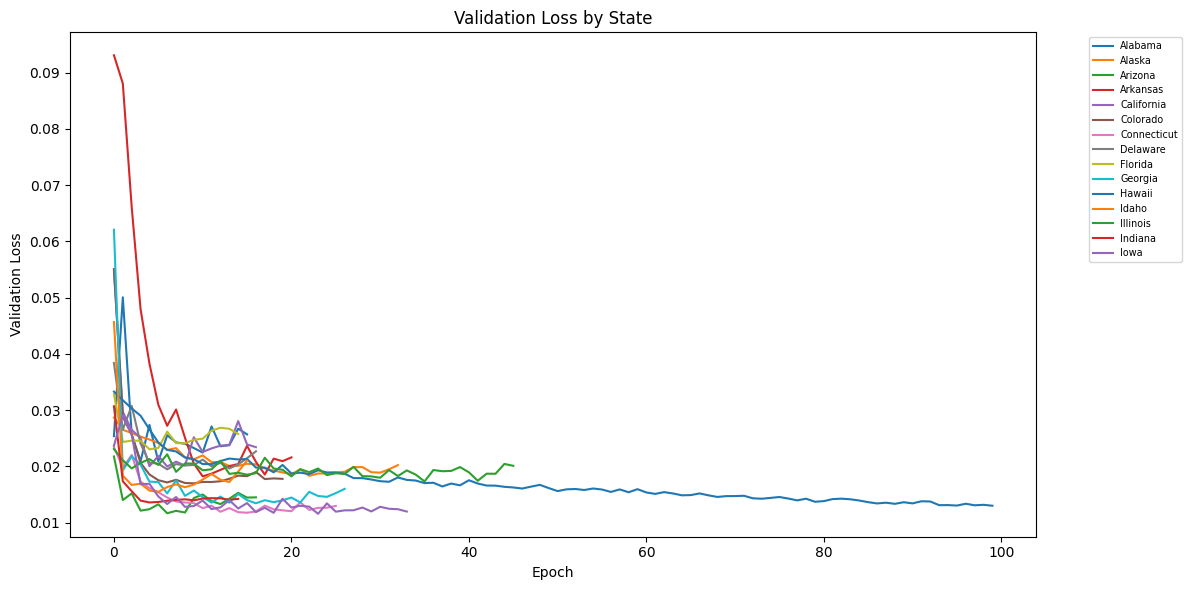

Hawaii: RMSE = 0.0154
Connecticut: RMSE = 0.0159
Delaware: RMSE = 0.0215
Idaho: RMSE = 0.0244
Indiana: RMSE = 0.0263
Iowa: RMSE = 0.0270
Illinois: RMSE = 0.0281
California: RMSE = 0.0412
Colorado: RMSE = 0.0444
Georgia: RMSE = 0.0535
Arizona: RMSE = 0.0581
Florida: RMSE = 0.0588
Alabama: RMSE = 0.0930
Arkansas: RMSE = 0.1103
Alaska: RMSE = 0.1191


In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv('Tony_data/merged_all_data_US_with_lfp.csv')
df['month'] = pd.to_datetime(df['month'], errors='coerce')
df = df.dropna(subset=['state'])

# Required columns
columns_needed = ['month', 'state', 'Unemployment Rate', 'initial_claims', 'median_income', 'population', 'lfp_rate']
df = df[columns_needed]

# Sliding window
def single_step_sampler(df, window):
    x, y = [], []
    for i in range(len(df) - window):
        x.append(df.iloc[i:i+window].values)
        y.append(df['Unemployment Rate'].iloc[i+window])
    return np.array(x), np.array(y)

# Scaling and splitting
def scale_and_split(df_state, window):
    df_state = df_state.sort_values('month').reset_index(drop=True)
    df_features = df_state.drop(columns=['month', 'state'])

    imputer = SimpleImputer()
    imputed = imputer.fit_transform(df_features)

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(imputed)

    df_scaled = pd.DataFrame(scaled, columns=df_features.columns)

    total = len(df_scaled)
    train_end = int(0.7 * total)
    val_end = int(0.9 * total)

    return (
        df_scaled.iloc[:train_end + window].reset_index(drop=True),
        df_scaled.iloc[train_end:val_end + window].reset_index(drop=True),
        df_scaled.iloc[val_end:].reset_index(drop=True)
    )

# Run model for each state
window = 20
states = df['state'].unique()
state_rmse = {}

plt.figure(figsize=(12, 6))

for state in states:
    try:
        df_state = df[df['state'] == state].copy()
        df_train, df_val, df_test = scale_and_split(df_state, window)

        X_train, y_train = single_step_sampler(df_train, window)
        X_val, y_val = single_step_sampler(df_val, window)
        X_test, y_test = single_step_sampler(df_test, window)

        model = Sequential([
            Input(shape=(window, X_train.shape[2])),
            LSTM(64),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dense(1)
        ])

        model.compile(loss='mse', optimizer='adam', metrics=['mae'])

        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=16,
            validation_data=(X_val, y_val),
            callbacks=[early_stop],
            verbose=0
        )

        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        state_rmse[state] = rmse

        plt.plot(history.history['val_loss'], label=state)

    except Exception as e:
        print(f"Error in {state}: {e}")

plt.title('Validation Loss by State')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(fontsize='x-small', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print RMSEs
for state, rmse in sorted(state_rmse.items(), key=lambda x: x[1]):
    print(f"{state}: RMSE = {rmse:.4f}")
